In [1]:
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
from scipy import stats
import seaborn as sns

# files

In [38]:
CL = "bj" # hepg2
PREFIX = "US.seqs.nopreprocessing"
PATH = "/wynton/home/ahituv/fongsl/EMF/US/data"
TRUTH = os.path.join(PATH, f"full_{CL}_ultrasound_MPRA.clean.transformed.standard.scaled.csv")  # US activity in HepG2

INPUT_DATA = os.path.join(PATH, f"{PREFIX}.txt") #"US.seqs.txt") # US library

PRED_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"
PRED = os.path.join(PRED_PATH, f"inference.{PREFIX}.tsv")  # legnet predictions
PRED_IN = os.path.join(PATH, "US.seqs.all.tsv")  # seq.id + seq

SEQ_SIZE = 270

# run legnet

In [51]:
def launchLegNet(input_file, seqsize):
    """ predict 18 bins using input sequence, write to output file, specify sequence size"""

    PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/"
    LEGNET_SH = os.path.join(PATH, "legnet_inference.sh")

    OUTPUT_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/"

    # str split to make output file a copy of the input file.
    infile = os.path.split(input_file)[1]
    outfile = os.path.join(OUTPUT_PATH, "inference." + ".".join(infile.split(".")[:-1]) + ".tsv")

    cmd = " ".join(["qsub -q gpu.q",
                   LEGNET_SH,
                   input_file,
                   outfile,
                   str(seqsize)
                   ])
    print(cmd)
    #os.system(cmd)
    
    if os.path.exists(outfile) is False:
        print("running...")
        os.system(cmd)
    else:
        print("skipping...", outfile)

## cmd

In [59]:
launchLegNet(INPUT_DATA, SEQ_SIZE)

qsub -q gpu.q /wynton/home/ahituv/fongsl/EMF/US/ml_emf/bin/legnet_inference.sh /wynton/home/ahituv/fongsl/EMF/US/data/US.seqs.nopreprocessing.txt /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/inference.US.seqs.nopreprocessing.tsv 270
skipping... /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/legnet/output/inference.US.seqs.nopreprocessing.tsv


**added N to line 1951 bc sequence had 269 nucleotides.**

# Truth v. Pred

In [53]:
# load truth
MEASURE = "mean"  # med


truth_cols = ["name", f'l2.ratio.{MEASURE}.ctrl',
              f'l2.ratio.{MEASURE}.us', f'delta.{MEASURE}']  # pick columns to load
truth = pd.read_csv(TRUTH, sep='\t', usecols=truth_cols)  # load data
truth = truth.rename(columns={"name": "seq.id"})  # rename column
truth["syn"] = truth["seq.id"].apply(lambda x: True if "SYN" in x else False)  # make column for synthetic sequence
truth.head()

,seq.id,l2.ratio.mean.ctrl,l2.ratio.mean.us,delta.mean,syn
0,SYNTHETIC:_The_motif_AAAATTGCTGACTTG_was_added...,-0.083398,-0.802372,-0.718974,True
1,SYNTHETIC:_Added_TTCCCCCC_TTGCTGCTCTAG_GGCGCAT...,-1.176254,-1.628824,-0.452570,True
2,SYNTHETIC:_Added_TCCTTATCTC_CACCTG_GTTCGAGACCA...,-0.594547,-1.000901,-0.406354,True
3,k562_atac_down_chr1:232594398-232594667,-0.464150,-0.170479,0.293671,False
4,hob_k27ac_up_chr7:38841102-38841371,-0.673728,-0.075443,0.598285,False


In [54]:
# load predictions
pred = pd.read_csv(PRED, sep='\t', header=None, names=["seq", "pred"])
pred.head()

,seq,pred
0,TAAAAGTTTGTACCCCCTCCCCGTCTGTATTGAGCTGCTCATGCAT...,8.070658
1,AATATTTTTAAACTCTTTATATTGTTGTTTATTACTATTTCTTAAA...,7.223330
2,CCTGAGTCATTTTCTTTTAAATGATGTATTTGTGCATTCCTTCATA...,3.807428
3,TAGTTATAATTGTTATACATTTAGAACATTTAATCTGGATTTTTGT...,5.460798
4,TGAACATATATATATATATATATATATATATATATATATATATATA...,6.763603


In [55]:
# load seq_id
seq_id = pd.read_csv(PRED_IN, sep='\t', names=["seq.id", "seq"])
seq_id.head()

,seq.id,seq
0,bj_k27ac_down_chr3:29837526-29837795,TAAAAGTTTGTACCCCCTCCCCGTCTGTATTGAGCTGCTCATGCAT...
1,bj_k27ac_down_chr3:29837260-29837529,AATATTTTTAAACTCTTTATATTGTTGTTTATTACTATTTCTTAAA...
2,bj_k27ac_down_chr3:29837792-29838061,CCTGAGTCATTTTCTTTTAAATGATGTATTTGTGCATTCCTTCATA...
3,bj_k27ac_down_chr3:29837392-29837661,TAGTTATAATTGTTATACATTTAGAACATTTAATCTGGATTTTTGT...
4,bj_k27ac_down_chr3:29837659-29837928,TGAACATATATATATATATATATATATATATATATATATATATATA...


## merge seq_id, pred, truth

In [56]:
# merge prediction with sequence id
pred = pd.merge(seq_id, pred)

# merge truth and prediction
merged = pd.merge(pred, truth)

## CTRL MPRA

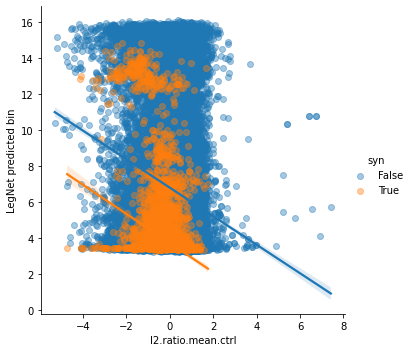

In [57]:
x=f'l2.ratio.{MEASURE}.ctrl'
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
           hue="syn", 
          scatter_kws={"alpha":0.4}, 
         )
g.set(ylabel="LegNet predicted bin")

In [58]:
# pearson, spearman
stats.pearsonr(merged[x], merged[y]), stats.spearmanr(merged[x], merged[y])

((-0.1134010835607972, 1.5240909244483828e-125),
 SpearmanrResult(correlation=-0.002501060514468567, pvalue=0.6003211949780384))

** with preprocessing**


HepG2:
        
     pearson ((-0.09270672195981426, 1.37678356775459e-84),
     SpearmanrResult(correlation=-0.07072198575765501, pvalue=6.607554719548206e-50))
 
BJ: 

    pearson ((-0.12885688780100837, 8.182412169194721e-162),
     SpearmanrResult(correlation=-0.09978023549407855, pvalue=1.692855719214293e-97))
     
** without preprocessing **

HepG2:
        
     pearson((-0.07694881248272836, 8.906539419755628e-59),
     SpearmanrResult(correlation=0.0290683544079478, pvalue=1.0689927425864015e-09))
     
BJ: 

    pearson ((-0.1134010835607972, 1.5240909244483828e-125),
     SpearmanrResult(correlation=-0.002501060514468567, pvalue=0.6003211949780384))

## US MPRA

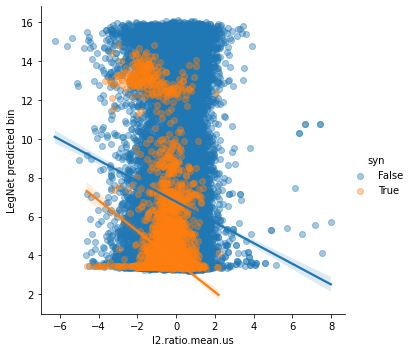

In [47]:
x=f'l2.ratio.{MEASURE}.us'
y="pred"
g = sns.lmplot(x=x, y=y, data=merged, 
           hue="syn", 
          scatter_kws={"alpha":0.4})
g.set(ylabel="LegNet predicted bin")

In [48]:
# pearson, spearman
stats.pearsonr(merged[x], merged[y]), stats.spearmanr(merged[x], merged[y])

((-0.042443118943237816, 5.828316551516101e-19),
 SpearmanrResult(correlation=0.056278011010031805, pvalue=3.958135999650938e-32))

** with preprocessing **


HepG2: 

    ((-0.040247051955186054, 3.020670048840718e-17),
     SpearmanrResult(correlation=-0.023321281860768518, pvalue=9.950923438915167e-07))
     
BJ:
        
        ((-0.05932499352729021, 1.6104881313891905e-35),
     SpearmanrResult(correlation=-0.047139647188981115, pvalue=5.052855395827331e-23))


** without preprocessing **


HepG2: 

    
    ((-0.024020539461729218, 4.671240421228968e-07),
     SpearmanrResult(correlation=0.08026444843449354, pvalue=8.318424597237396e-64))
     
BJ:

        ((-0.042443118943237816, 5.828316551516101e-19),
     SpearmanrResult(correlation=0.056278011010031805, pvalue=3.958135999650938e-32))

note - predictions look worse for control than for US. Prediction scores are terrible! Approximate zero or slightly negative. 

# US-DELTA

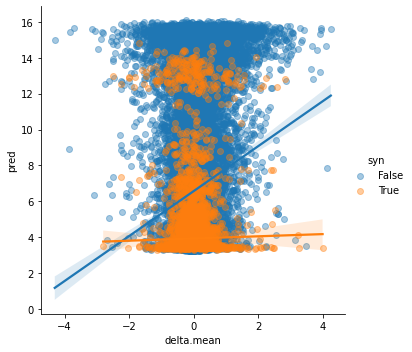

In [49]:
x=f'delta.{MEASURE}'
y="pred"
sns.lmplot(x=x, y=y, data=merged, 
           hue="syn", 
          scatter_kws={"alpha":0.4})
g.set(ylabel="LegNet predicted bin")

In [50]:
# pearson, spearman
stats.pearsonr(merged[x], merged[y]), stats.spearmanr(merged[x], merged[y])

((0.15080247947394537, 1.5329946641636853e-221),
 SpearmanrResult(correlation=0.11333516863267, pvalue=2.1258770776434572e-125))

** with preprocessing ** (may affect the sequence that is getting tested)


HepG2: 

        ((0.11028964657613562, 4.0065853930730226e-119),
     SpearmanrResult(correlation=0.0818088452951637, pvalue=3.1946030441320316e-66))
BJ:
        
        ((0.1477382179559476, 1.290588458697689e-212),
         SpearmanrResult(correlation=0.09195570645522853, pvalue=4.9354991861700444e-83))
         
** without preprocessing **

HepG2:
    
    pearson ((0.11114323729375934, 5.902872258704083e-121),
     SpearmanrResult(correlation=0.08716279731811634, pvalue=5.902617037094986e-75))
    

BJ:
      
      ((0.15080247947394537, 1.5329946641636853e-221),
     SpearmanrResult(correlation=0.11333516863267, pvalue=2.1258770776434572e-125))

        

- delta activity is better than predicting actual MPRA activity?

- Synthetic sequences are negatively correlated? 

- accuracy ~ sequence conservation with Yeast? 

- is control number 2 impacting interpretations? 

- mean? Similar to median

- retrain? 